In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
# Import DATA Set (.mat file)
data = sio.loadmat('sentimentdataset.mat', chars_as_strings=1, matlab_compatible=1)

# sentimentdataset.mat file contains 3 matlab variables
# bagofword: 198 X 29717 double
# sentiment: 198 X 1     double
# word:      29717 X 1  cell -> Only use 2000 cases in this class.

bagofword = data['bagofword'];
sentiment = data['sentiment']; 
sentiment = sentiment.astype(int);
words = data['word'];

# Convert MATLAB Cell into python array
word = []
for n in range(2000):
    word = word + [str(''.join(letter)) for letter in words[n][0]]

In [3]:
cell = 10;
replication = 2;
numTesting = 50;
numWord = 2000;

trainingAccuracy = np.zeros((replication, 10));
testingAccuracy = np.zeros((replication,10));
avgTraining = np.zeros((cell,1));
stdTraining = np.zeros((cell,1));
avgTesting = np.zeros((cell,1));
stdTesting = np.zeros((cell,1));

for M in range(1,cell+1):
    N = M * 10;
    for rep in range(replication):
        sample = np.random.permutation(np.arange(198))
        
        X = bagofword[sample];
        Y = sentiment[sample];
        
        cntXbyY = np.ones((numWord,2))/1000;
        
        for i in range(numWord):
            for j in range(N):
                if X[j,i] >= 1:
                    cntXbyY[i,Y[j]] = cntXbyY[i,Y[j]] + 1;
        
        cntY = np.zeros((2,1));
        for j in range(N):
            if Y[j] == 0:
                cntY[0] = cntY[0] + 1;
            else:
                cntY[1] = cntY[1] + 1;
        
        probsXbyY = np.zeros((numWord, 2));
        for i in range(numWord):
            for j in range(2):
                probsXbyY[i,j] = cntXbyY[i,j] / float(cntY[j]);
                
        probsY = np.zeros((2,1));
        for j in range(2):
            probsY[j] = cntY[j] / float(cntY[0] + cntY[1]);
            
        probsSentiment = np.zeros((198,2));
        for i in range(198):
            for k in range(2):
                probsSentiment[i,k] = 1;
                for j in range(numWord):
                    if X[i,j] == 1:
                        probsSentiment[i,k] = probsSentiment[i,k] * probsXbyY[j,k];
                    else:
                        probsSentiment[i,k] = probsSentiment[i,k] * (1 - probsXbyY[j,k]);
                probsSentiment[i,k] = probsSentiment[i,k] * probsY[k];
        
        #logProbsSentiment = np.zeros((198,2));
        #for i in range(198):
        #    for k in range(2):
        #        logProbsSentiment[i,k] = 0;
        #        for j in range(numWord):
        #            if X[i,j] == 1:
        #                logProbsSentiment[i,k] = logProbsSentiment[i,k] + log(probsXbyY[j,k]);
        #            else:
        #                logProbsSentiment[i,k] = logProbsSentiment[i,k] + log(1 - probsXbyY[j,k]);
        #        logProbsSentiment[i,k] = logProbsSentiment[i,k] + log(probsY[k,0]);
        
        
        estSentiment = np.zeros((198,1));
        for i in range(198):
            if probsSentiment[i,0] > probsSentiment[i,1]:
                estSentiment[i] = 0;
            else:
                estSentiment[i] = 1;
        
        cntCorrect = 0;
        for i in range(N):
            if estSentiment[i] == Y[i]:
                cntCorrect = cntCorrect + 1;
        trainingAccuracy[rep,M-1] = cntCorrect / float(N);
        
        cntCorrect = 0;
        for i  in range(N,N+numTesting+1):
            if estSentiment[i] == Y[i]:
                cntCorrect = cntCorrect + 1;
        testingAccuracy[rep,M-1] = cntCorrect / float(numTesting);
        
    avgTraining[M-1] = np.mean(trainingAccuracy[:,M-1]);
    avgTesting[M-1] = np.mean(testingAccuracy[:,M-1]);
    stdTraining[M-1] = np.std(trainingAccuracy[:,M-1]);
    stdTesting[M-1] = np.std(testingAccuracy[:,M-1]);

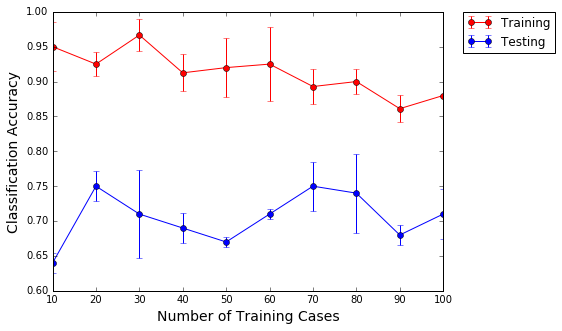

In [4]:
plt.figure(1, figsize=(7,5))
plt.errorbar(np.dot(10,range(1,cell+1)),avgTraining,yerr = stdTraining/np.sqrt(replication), fmt='-o', color='r', label = "Training");
plt.errorbar(np.dot(10,range(1,cell+1)),avgTesting,yerr = stdTesting/np.sqrt(replication),  fmt='-o', color='b', label = "Testing");

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Number of Training Cases', fontsize = 14)
plt.ylabel('Classification Accuracy', fontsize = 14)

plt.show();